# ltu-ili evidence estimation
This is a tutorial for using ltu-ili evidence networks in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Generate model

In [2]:
N =5
n_params = N
ystd = np.sqrt(0.001*N)*np.linspace(2.5,4., N)**2.
x = np.linspace(0,np.pi/2,N)

In [3]:

from scipy.stats import norm, multivariate_normal

def mu_data(x, theta, mat_A=None):
    """
    Calculate data mean as function of parameters: $\mu(\theta)$
    :param x: data coordinates x
    :param theta: model parameters $\theta$
    :param mat_A: matrix $A_{ij}$ for linear model
    :return: mean data vector $\mu(\theta)$
    """
    theta = np.array(theta)
    if mat_A is None:
        mat_A = matrix_operation(np.array(x), theta.shape[-1])
    return np.inner(mat_A, theta)

def coordinate_function(x, j):
    """
    Defines function for linear model matrix: $A_{ij}=f_j(x_i)$
    :param x: data coordinates x
    :param j: parameter index corresponding to: $\theta_j$
    :return: f(x,j) = cos(x * (j + 1/2))
    """
    return np.cos((j - 0.5) * x)

def matrix_operation(x, n_params):
    """
    Generate matrix $A_{ij}$ for linear model
    :param x: data coordinates x
    :param n_params: number of parameters in $\theta$
    :return: matrix $A_{ij}$
    """
    mat_A = np.ones((x.shape[0], n_params))
    for j in np.arange(n_params):
        if j>0:
            mat_A[:, j] = coordinate_function(x, j)
        else:
            mat_A[:, j] = x * 2.
    return mat_A

def evidence_analytic(y, mat_A, mu_prior, cov_prior, cov_data):
    """
    Analytic evidence calculation for model
    :param y: noisy data y
    :param mat_A: matrix $A_{ij}$ for linear model
    :param mu_prior:  prior mean for parameters
    :param cov_prior: prior covariance for parameters
    :param cov_data:  data covariance
    :return:
    """
    mu_evidence = np.dot(mat_A, np.array(mu_prior))
    cov_evidence = np.dot(np.dot(mat_A, np.array(cov_prior)),
                          mat_A.T) + cov_data
    return multivariate_normal.pdf(y, mean=mu_evidence, cov=cov_evidence)

def bayes_factor_theta_0(y, x, n_params, ystd):
    """
    Bayes factor calculation for nested model without $\theta{j=0}=0$
    (logK > 0 implies $\theta_0=0$ is disfavoured)
    :param y: noisy data y
    :param x: data coordinates x
    :param n_params: number of parameters in $\theta$
    :param ystd: standard deviation of data: $\sqrt(\diag(Cov))$
    :return: Bayes factor
    """
    baseline_evidence = evidence_analytic(y, matrix_operation(x, n_params), np.zeros(n_params),
                                          np.identity(n_params), np.identity(len(ystd)) * ystd ** 2)

    alternative_evidence = evidence_analytic(y, matrix_operation(x, n_params)[:, 1:], np.zeros(n_params)[1:],
                                             np.identity(n_params)[1:, 1:], np.identity(len(ystd)) * ystd ** 2)

    return baseline_evidence / alternative_evidence

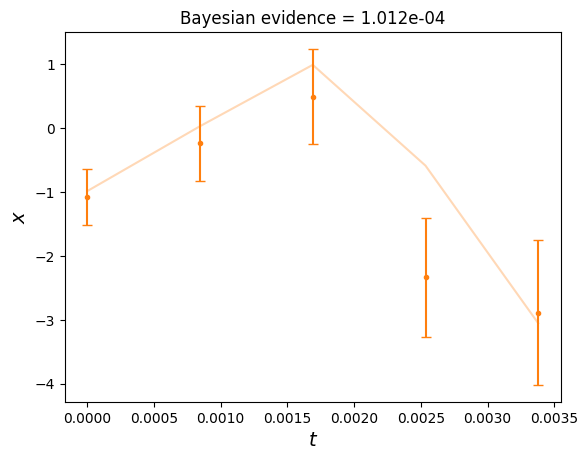

In [4]:
theta_true = np.random.normal(size=(n_params))
mu_true = mu_data(x, theta_true)
y = np.random.normal(mu_true, ystd)

evidence_y = evidence_analytic(y, matrix_operation(x, n_params), np.zeros(n_params),
                                      np.identity(n_params), np.identity(len(ystd)) * ystd**2)

plt.plot(x*0.5*np.pi*0.5/365., mu_true, c='C1' , alpha=0.3)
plt.errorbar(x*0.5*np.pi*0.5/365., y, yerr=ystd, fmt='.C1', capsize=3.45)
plt.xlabel(r'$t$', fontsize=14),plt.ylabel(r'$x$', fontsize=14)
plt.title('Bayesian evidence = ' + str("%.3e" % evidence_y));

In [5]:
# Generate data
Nexamples = 10000
prior_mu1, prior_std1 = 0., 1.
prior_mu2, prior_std2 = 0., 0.

theta1 = np.random.normal(prior_mu1, prior_std1, size=(Nexamples, n_params))
theta2 = np.random.normal(prior_mu2, prior_std2, size=(Nexamples, n_params))

mu1 = mu_data(x, theta1).T
mu2 = mu_data(x, theta2).T

y1 = np.random.normal(mu1, ystd)
y2 = np.random.normal(mu2, ystd)

loader1 = NumpyLoader(x=y1, theta=theta1)
loader2 = NumpyLoader(x=y2, theta=theta2)

K1 = bayes_factor_theta_0(y1, x, n_params, ystd) 
K2 = bayes_factor_theta_0(y2, x, n_params, ystd)

In [6]:
# Generate an observed point
theta_obs = np.random.normal(prior_mu1, prior_std1, size=(1, n_params))
mu_obs = mu_data(x, theta_obs)
y_obs = np.random.normal(mu_obs, ystd)

## Harmonic

In [7]:
## Setup the inference runner

# define a prior
prior = ili.utils.IndependentNormal(
    loc=prior_mu1*np.ones(n_params),
    scale=prior_std1*np.ones(n_params),
    device=device
)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [8]:
# train the model
posterior_ensemble, summaries = runner(loader=loader1)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 128

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 98 129 epochs.

INFO:root:It took 144.17303895950317 seconds to train models.


 Neural network successfully converged after 99 epochs.

In [9]:
samps = posterior_ensemble.sample((10000,), x=y_obs[0], show_progress_bars=False)
lnprob = posterior_ensemble.log_prob(samps, x=y_obs[0])

(-2.0, 2.0)

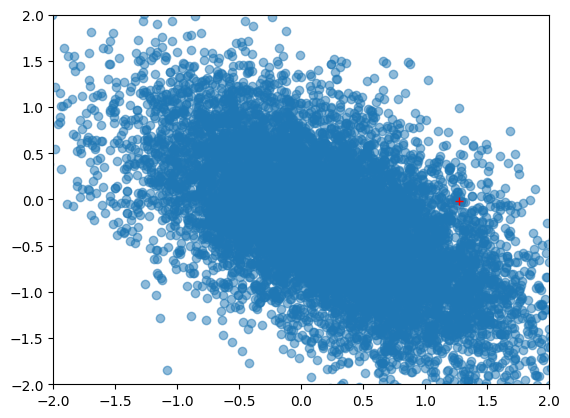

In [10]:
i=0
i += 1
plt.plot(samps[:, i], samps[:, i+1], 'o', alpha=0.5)
plt.plot(theta_obs[0, i], theta_obs[0, i+1], '+', color='r', label='True')
plt.xlim(-2,2)
plt.ylim(-2,2)

In [11]:
from ili.evidence import HarmonicEvidence

estimator = HarmonicEvidence()

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: '/opt/homebrew/anaconda3/envs/ili-torch/bin/../lib/libtpu.so' (no such file), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file), '/Users/maho/git/ltu-ili/notebooks/libtpu.so' (no such file)


In [19]:
ln_inv_evidence, err_ln_inv_evidence = estimator.from_posterior(
    posterior_ensemble, x=y_obs[0],
    show_progress_bars=False
)

Training NF: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


In [20]:
ln_inv_evidence, err_ln_inv_evidence

(0.0036440492, (-inf, nan))

## Evidence Networks

In [170]:
from ili.evidence.utils import EvidenceNetworkSimple, ExpLoss, POPExpLoss

In [175]:
net = EvidenceNetworkSimple(
    N, 
    layer_width=16, added_layers=2,
    batch_norm_flag=1, alpha=2
)

In [181]:
x = np.concatenate([y1, y2], axis=0)
theta = np.concatenate([np.zeros(len(y1)), np.ones(len(y2))], axis=0)
K = np.concatenate([K1, K2], axis=0)

shuffle = np.random.choice(len(x), len(x), replace=False)
x = x[shuffle]
theta = theta[shuffle]
K = K[shuffle]

scale = 40*np.std(x, axis=0)

In [182]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

in_train = np.random.rand(len(x)) < 0.8

train_dataset = TensorDataset(
    torch.tensor(x[in_train], dtype=torch.float32),
    torch.tensor(theta[in_train], dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(x[~in_train], dtype=torch.float32),
    torch.tensor(theta[~in_train], dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Ktest = K[~in_train]

In [178]:
import tqdm
lossfn = ExpLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
Nepochs = 20

trloss_rec = []
valoss_rec = []
for i in range(Nepochs):
    trloss = 0
    net.train()
    for x, theta in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        pred = net(x)
        loss = lossfn(pred, theta)
        loss.backward()
        optimizer.step()
        trloss += loss.item()

    with torch.no_grad():
        net.eval()
        valoss = 0
        for x, theta in test_loader:
            pred = net(x)
            loss = lossfn(pred, theta)
            valoss += loss.item()
    trloss /= len(train_dataset)
    valoss /= len(test_dataset)
    
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    print(f'Epoch {i+1}/{Nepochs}, Train Loss: {trloss:.5f}, Val Loss: {valoss:.5f}')

100%|██████████| 500/500 [00:01<00:00, 278.99it/s]


Epoch 1/20, Train Loss: 32.02605, Val Loss: 31.95134


100%|██████████| 500/500 [00:01<00:00, 290.04it/s]


Epoch 2/20, Train Loss: 31.99366, Val Loss: 31.94527


100%|██████████| 500/500 [00:01<00:00, 287.83it/s]


Epoch 3/20, Train Loss: 31.98911, Val Loss: 31.94099


100%|██████████| 500/500 [00:01<00:00, 283.54it/s]


Epoch 4/20, Train Loss: 31.98719, Val Loss: 31.94001


100%|██████████| 500/500 [00:01<00:00, 276.53it/s]


Epoch 5/20, Train Loss: 31.98623, Val Loss: 31.93891


100%|██████████| 500/500 [00:01<00:00, 267.15it/s]


Epoch 6/20, Train Loss: 31.98564, Val Loss: 31.93961


100%|██████████| 500/500 [00:01<00:00, 258.26it/s]


Epoch 7/20, Train Loss: 31.98532, Val Loss: 31.93873


100%|██████████| 500/500 [00:01<00:00, 287.35it/s]


Epoch 8/20, Train Loss: 31.98503, Val Loss: 31.93924


100%|██████████| 500/500 [00:01<00:00, 258.35it/s]


Epoch 9/20, Train Loss: 31.98482, Val Loss: 31.93921


100%|██████████| 500/500 [00:01<00:00, 291.78it/s]


Epoch 10/20, Train Loss: 31.98468, Val Loss: 31.93960


100%|██████████| 500/500 [00:01<00:00, 296.33it/s]


Epoch 11/20, Train Loss: 31.98449, Val Loss: 31.93984


100%|██████████| 500/500 [00:01<00:00, 296.79it/s]


Epoch 12/20, Train Loss: 31.98442, Val Loss: 31.93915


100%|██████████| 500/500 [00:01<00:00, 293.11it/s]


Epoch 13/20, Train Loss: 31.98435, Val Loss: 31.93946


100%|██████████| 500/500 [00:01<00:00, 286.60it/s]


Epoch 14/20, Train Loss: 31.98427, Val Loss: 31.93872


100%|██████████| 500/500 [00:01<00:00, 291.20it/s]


Epoch 15/20, Train Loss: 31.98421, Val Loss: 31.93893


100%|██████████| 500/500 [00:01<00:00, 293.41it/s]


Epoch 16/20, Train Loss: 31.98417, Val Loss: 31.93842


100%|██████████| 500/500 [00:01<00:00, 260.32it/s]


Epoch 17/20, Train Loss: 31.98411, Val Loss: 31.93848


100%|██████████| 500/500 [00:01<00:00, 263.99it/s]


Epoch 18/20, Train Loss: 31.98408, Val Loss: 31.93857


100%|██████████| 500/500 [00:01<00:00, 266.51it/s]


Epoch 19/20, Train Loss: 31.98408, Val Loss: 31.93816


100%|██████████| 500/500 [00:01<00:00, 290.58it/s]


Epoch 20/20, Train Loss: 31.98403, Val Loss: 31.93867


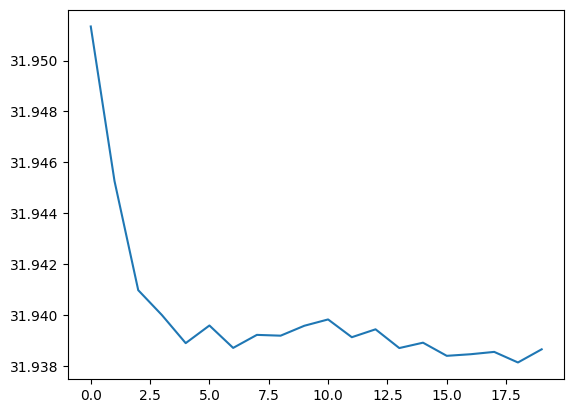

In [179]:
# plt.plot(trloss_rec, label='Train Loss')
plt.plot(valoss_rec, label='Val Loss')

In [183]:
preds = []
for x, theta in test_loader:
    pred = net(x)
    preds.append(pred)
preds = torch.cat(preds, dim=0).detach().numpy()

Text(0, 0.5, 'Predicted log(K)')

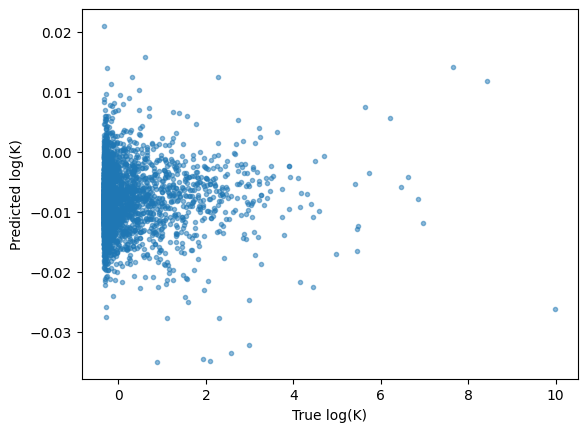

In [189]:
plt.plot(np.log10(Ktest), preds, '.', alpha=0.5)
plt.xlabel('True log(K)')
plt.ylabel('Predicted log(K)')